In [1]:
#Shane Butler 
#S00189384

In [147]:
#Imports.
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import keras_tuner as kt
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report,ConfusionMatrixDisplay

In [3]:
#Read data.
df_training_data = pd.read_csv("PokemonDataSet.csv")
df_test_data = pd.read_csv("PokemonGen8.csv")

In [443]:
#Shuffle dataframes.
df_training_data = df_training_data.sample(frac=1,random_state = 5).reset_index(drop=True)
df_test_data = df_test_data.sample(frac=1,random_state = 5).reset_index(drop=True)

In [444]:
#For training dataframe - show legendary as either 0 or 1 (same as test dataframe).
df_training_data["Legendary"] = df_training_data["Legendary"].astype(int)

In [445]:
features = ["HP","Attack","Defense","Sp_Atk","Sp_Def","Speed"]

#Rename certain columns in test df.
df_test_data = df_test_data.rename(columns={"Att":"Attack","Def":"Defense","S.Att":"Sp_Atk","S.Def":"Sp_Def","Spd":"Speed",})

In [446]:
#Create x train,x test etc. from dataframe. 
X_train = df_training_data[features].values
y_train = df_training_data["Legendary"].values
X_test = df_test_data[features].values
y_test = df_test_data["Legendary"].values

In [447]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

In [506]:
pd.set_option('display.max_columns', None)

In [448]:
def ShowTrainingValidationAccuracy(history,num_epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs_range = range(num_epochs)
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()


def ShowTrainingValidationLoss(history,num_epochs):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [449]:
#Method to display confusion matrix of a model.
#Only takes into account data we're using which is the images. 
#Code to display confusion matrix is from here: https://blog.finxter.com/how-to-plot-sklearn-confusion-matrix-with-labels/
def PrintConfusionMatrixOfModel(y_test,y_predicted,title):
    lables = [i for i in range(0,2)]
    c_matrix = confusion_matrix(y_test,y_predicted)

    c_matrix_display = ConfusionMatrixDisplay(c_matrix,display_labels=lables)
    c_matrix_display.plot()
    c_matrix_display.ax_.set(
                title=title, 
                xlabel='Predicted', 
                ylabel='Actual')
    plt.show()

In [450]:
def GetFalseNegativePokemon(dataframe,y_test,y_predict):
    legendary_indexes = [i for i, element in enumerate(y_test) if element == 1]
    false_negative_pokemon = [dataframe.iloc[leg_index] for leg_index in legendary_indexes if y_predict[leg_index] != 1 ]
    return pd.DataFrame(false_negative_pokemon) 

In [451]:
#Getting all false positive pokemon predicted by model.
def GetFalsePositivePokemon(dataframe,y_test,y_predict):
    false_positive_pokemon = [dataframe.iloc[i] for i in range(len(y_predict)) if y_predict[i] == 1 if y_test[i] == 0]
    return pd.DataFrame(false_positive_pokemon) 

In [452]:
#Getting all the correctly predicted legendaries predicted by the model.
def GetCorrectlyPredictedLegendaryPokemon(dataframe,y_test,y_predict):
    correctly_predicted_legendaries = [dataframe.iloc[i] for i in range(len(y_predict)) if y_predict[i] == 1 if y_test[i] == 1]
    return pd.DataFrame(correctly_predicted_legendaries)

In [453]:
def PrintLossAccuracyGraphs(model_history):
    epochs_run = len(model_history.history['loss'])    
    ShowTrainingValidationAccuracy(history,epochs_run)
    ShowTrainingValidationLoss(history,epochs_run)

In [454]:
def GetTrainingAccuracyOfModel(model,X_train):
    y_train_predictions_prob = model.predict(X_train)
    y_train_predictions = y_train_predictions_prob.round()    
    return accuracy_score(y_train,y_train_predictions)

In [455]:
def GetTestAccuracyOfModel(model,X_test):
    y_test_predictions_prob = model.predict(X_test)
    y_test_predictions = y_test_predictions_prob.round()
    return accuracy_score(y_test,y_test_predictions)

In [528]:
def GetMeanOfPokemonFeaturesInDataframe(dataframe):
    return dataframe[features].mean(axis=1).mean()

In [543]:
def PrintMeanOfPokemonFeaturesInDataframe(dataframe_name,dataframe):
    print("Mean of features of {} is {}".format(dataframe_name,GetMeanOfPokemonFeaturesInDataframe(dataframe)))

In [456]:
def CreateModel1():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(12,input_shape=(6,), activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1,activation="sigmoid"))
    #optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum = 0.2)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])   
    return model

In [457]:
def CreateModel2():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(4,input_shape=(6,), activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(4))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1,activation="sigmoid"))
    #optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum = 0.2)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])   
    return model

In [458]:
def CreateModel3():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(6,input_shape=(6,), activation='relu',))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(1,activation="sigmoid"))
    #optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum = 0.2)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])   
    return model

In [488]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",mode="min",patience=30,verbose=1)

In [588]:
#Finding mean of features of each pokemon (legendary and non-legendary) in test and training datasets.
df_non_legendary_pokemon_training = df_training_data[df_training_data['Legendary'] == 0]
PrintMeanOfPokemonFeaturesInDataframe("non legendary training pokemon",df_non_legendary_pokemon_training)

df_legendary_pokemon_training = df_training_data[df_training_data['Legendary'] == 1]
PrintMeanOfPokemonFeaturesInDataframe("legendary training pokemon",df_legendary_pokemon_training)

Mean of features of non legendary training pokemon is 69.53560090702949
Mean of features of legendary training pokemon is 106.23076923076924


In [589]:
df_non_legendary_pokemon_test = df_test_data[df_test_data['Legendary'] == 0]
PrintMeanOfPokemonFeaturesInDataframe("non legendary test pokemon",df_non_legendary_pokemon_test)

df_legendary_pokemon_test = df_test_data[df_test_data['Legendary'] == 1]
PrintMeanOfPokemonFeaturesInDataframe("legendary test pokemon",df_legendary_pokemon_test)

Mean of features of non legendary test pokemon is 67.57430730478586
Mean of features of legendary test pokemon is 112.77777777777779


In [460]:
model = CreateModel1()
history = model.fit(X_train, y_train,validation_split = 0.1,batch_size=64,epochs=500,callbacks=[earlystopping])

Epoch 1/500
12/12 [==============================] - 0s 13ms/step - loss: 7.5851 - accuracy: 0.4167 - val_loss: 4.3896 - val_accuracy: 0.4875
Epoch 2/500
12/12 [==============================] - 0s 2ms/step - loss: 5.9085 - accuracy: 0.5500 - val_loss: 3.1789 - val_accuracy: 0.6750
Epoch 3/500
12/12 [==============================] - 0s 2ms/step - loss: 4.8015 - accuracy: 0.6431 - val_loss: 2.7526 - val_accuracy: 0.7500
Epoch 4/500
12/12 [==============================] - 0s 3ms/step - loss: 4.2324 - accuracy: 0.6903 - val_loss: 2.5158 - val_accuracy: 0.7625
Epoch 5/500
12/12 [==============================] - 0s 3ms/step - loss: 3.9791 - accuracy: 0.6986 - val_loss: 2.3469 - val_accuracy: 0.8000
Epoch 6/500
12/12 [==============================] - 0s 2ms/step - loss: 3.5841 - accuracy: 0.6958 - val_loss: 2.2750 - val_accuracy: 0.8125
Epoch 7/500
12/12 [==============================] - 0s 2ms/step - loss: 3.1167 - accuracy: 0.7319 - val_loss: 2.1811 - val_accuracy: 0.8125
Epoch 8/500


Epoch 59/500
12/12 [==============================] - 0s 2ms/step - loss: 0.4512 - accuracy: 0.9125 - val_loss: 0.4978 - val_accuracy: 0.8875
Epoch 60/500
12/12 [==============================] - 0s 2ms/step - loss: 0.4636 - accuracy: 0.9125 - val_loss: 0.4914 - val_accuracy: 0.8875
Epoch 61/500
12/12 [==============================] - 0s 2ms/step - loss: 0.4143 - accuracy: 0.9125 - val_loss: 0.4936 - val_accuracy: 0.8875
Epoch 62/500
12/12 [==============================] - 0s 3ms/step - loss: 0.4309 - accuracy: 0.9111 - val_loss: 0.5020 - val_accuracy: 0.8875
Epoch 63/500
12/12 [==============================] - 0s 2ms/step - loss: 0.4266 - accuracy: 0.9153 - val_loss: 0.4993 - val_accuracy: 0.8875
Epoch 64/500
12/12 [==============================] - 0s 3ms/step - loss: 0.4238 - accuracy: 0.9167 - val_loss: 0.4955 - val_accuracy: 0.8875
Epoch 65/500
12/12 [==============================] - 0s 3ms/step - loss: 0.4162 - accuracy: 0.9167 - val_loss: 0.4899 - val_accuracy: 0.8875
Epoch 

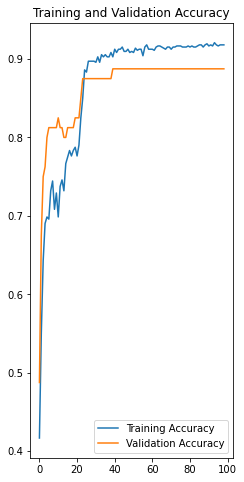

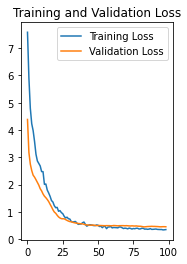

In [461]:
PrintLossAccuracyGraphs(history)

In [462]:
_,train_acc = model.evaluate(X_train, y_train)
_,test_acc = model.evaluate(X_test, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

13/13 [==============================] - 0s 750us/step - loss: 0.1847 - accuracy: 0.9925
Train: 0.915, Test: 0.993


In [556]:
#TRAINING SET.
y_train_predictions_prob = model.predict(X_train)
y_train_predictions = y_train_predictions_prob.round()

In [557]:
print(classification_report(y_train, y_train_predictions))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       735
           1       0.00      0.00      0.00        65

    accuracy                           0.92       800
   macro avg       0.46      0.50      0.48       800
weighted avg       0.84      0.92      0.88       800



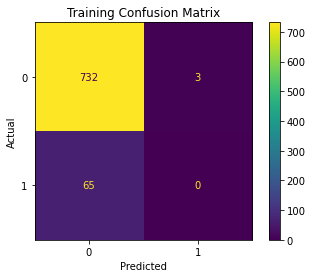

In [464]:
PrintConfusionMatrixOfModel(y_train,y_train_predictions,"Training Confusion Matrix")

In [465]:
#test = [index for index,value in enumerate(y_train_predictions) if value > 0.75]
#test

#y_train_legendary_indexes = [i for i, element in enumerate(y_train) if element == 1]

In [466]:
GetFalseNegativePokemon(df_training_data,y_train,y_train_predictions)

,ID,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,Legendary
6,271,Ho-oh,Fire,Flying,680,106,130,90,110,154,90,2,1
18,704,TornadusTherian Forme,Flying,NaN,580,79,100,80,110,90,121,5,1
27,421,LatiosMega Latios,Dragon,Psychic,700,80,130,100,160,120,110,3,1
40,263,Raikou,Electric,NaN,580,90,85,75,115,100,115,2,1
50,425,GroudonPrimal Groudon,Ground,Fire,770,100,180,160,150,90,90,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,431,DeoxysDefense Forme,Psychic,NaN,600,50,70,160,70,160,90,3,1
771,707,Reshiram,Dragon,Fire,680,100,120,100,150,120,90,5,1
773,164,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,1
777,157,Articuno,Ice,Flying,580,90,85,100,95,125,85,1,1


In [467]:
GetFalsePositivePokemon(df_training_data,y_train,y_train_predictions)

,ID,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,Legendary
368,262,Blissey,Normal,NaN,540,255,10,10,75,135,55,2,0
606,122,Chansey,Normal,NaN,450,250,5,5,35,105,50,1,0
643,489,Happiny,Normal,NaN,220,100,5,5,15,65,30,4,0


In [468]:
GetCorrectlyPredictedLegendaryPokemon(df_training_data,y_train,y_train_predictions)

""


In [469]:
#TEST SET.
y_test_predictions_prob = model.predict(X_test)
y_test_predictions = y_test_predictions_prob.round()

In [558]:
print(classification_report(y_test, y_test_predictions))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       397
           1       0.18      1.00      0.30         3

    accuracy                           0.96       400
   macro avg       0.59      0.98      0.64       400
weighted avg       0.99      0.96      0.98       400



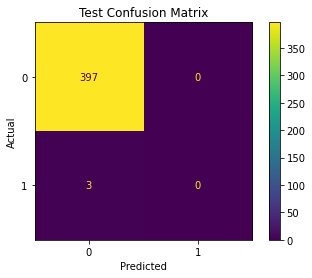

In [471]:
PrintConfusionMatrixOfModel(y_test,y_test_predictions,"Test Confusion Matrix")

In [472]:
GetFalseNegativePokemon(df_test_data,y_test,y_test_predictions)

,No.,Name,Ability1,Ability2,Hidden_Ability,Type1,Type2,HP,Attack,Defense,...,Sp_Def,Speed,Weight_kg,Height_m,Weight_lbs,Height_ft,Cap_Rate,Egg_Steps,Classification,Legendary
25,399,Zamazenta,Dauntless Shield,NaN,NaN,fighting,NaN,92,130,115,...,115,138,210.0,2.9,463.0,9.500,10,30720,Warrior Pokémon,1
78,400,Eternatus,Pressure,NaN,NaN,poison,dragon,140,85,95,...,95,130,950.0,20.0,2094.4,65.583,255,30720,Gigantic Pokémon,1
384,398,Zacian,Intrepid Sword,NaN,NaN,fairy,NaN,92,130,115,...,115,138,110.0,2.8,242.5,9.167,10,30720,Warrior Pokémon,1


In [473]:
GetFalsePositivePokemon(df_test_data,y_test,y_test_predictions)

""


In [474]:
GetCorrectlyPredictedLegendaryPokemon(df_test_data,y_test,y_test_predictions)

""


In [489]:
#Model 1 scaled - CHOSEN MODEL.
model_scaled = CreateModel1()
history = model_scaled.fit(X_train_scaled, y_train,validation_split = 0.1,batch_size=64,epochs=500,callbacks=[earlystopping])

Epoch 1/500
12/12 [==============================] - 0s 13ms/step - loss: 0.7870 - accuracy: 0.1083 - val_loss: 0.7558 - val_accuracy: 0.1250
Epoch 2/500
12/12 [==============================] - 0s 3ms/step - loss: 0.7523 - accuracy: 0.2097 - val_loss: 0.7296 - val_accuracy: 0.1875
Epoch 3/500
12/12 [==============================] - 0s 3ms/step - loss: 0.7266 - accuracy: 0.2806 - val_loss: 0.7052 - val_accuracy: 0.3750
Epoch 4/500
12/12 [==============================] - 0s 2ms/step - loss: 0.6988 - accuracy: 0.4736 - val_loss: 0.6817 - val_accuracy: 0.6125
Epoch 5/500
12/12 [==============================] - 0s 2ms/step - loss: 0.6729 - accuracy: 0.6500 - val_loss: 0.6582 - val_accuracy: 0.7750
Epoch 6/500
12/12 [==============================] - 0s 2ms/step - loss: 0.6440 - accuracy: 0.8111 - val_loss: 0.6349 - val_accuracy: 0.8875
Epoch 7/500
12/12 [==============================] - 0s 2ms/step - loss: 0.6228 - accuracy: 0.8556 - val_loss: 0.6122 - val_accuracy: 0.9000
Epoch 8/500


Epoch 116/500
12/12 [==============================] - 0s 2ms/step - loss: 0.2557 - accuracy: 0.9236 - val_loss: 0.3007 - val_accuracy: 0.8875
Epoch 117/500
12/12 [==============================] - 0s 2ms/step - loss: 0.2713 - accuracy: 0.9181 - val_loss: 0.3001 - val_accuracy: 0.8875
Epoch 118/500
12/12 [==============================] - 0s 2ms/step - loss: 0.2731 - accuracy: 0.9222 - val_loss: 0.2997 - val_accuracy: 0.8875
Epoch 119/500
12/12 [==============================] - 0s 2ms/step - loss: 0.2665 - accuracy: 0.9194 - val_loss: 0.2973 - val_accuracy: 0.8875
Epoch 120/500
12/12 [==============================] - 0s 2ms/step - loss: 0.2499 - accuracy: 0.9250 - val_loss: 0.2943 - val_accuracy: 0.9000
Epoch 121/500
12/12 [==============================] - 0s 2ms/step - loss: 0.2478 - accuracy: 0.9222 - val_loss: 0.2923 - val_accuracy: 0.9000
Epoch 122/500
12/12 [==============================] - 0s 2ms/step - loss: 0.2565 - accuracy: 0.9292 - val_loss: 0.2921 - val_accuracy: 0.9000

12/12 [==============================] - 0s 3ms/step - loss: 0.1759 - accuracy: 0.9333 - val_loss: 0.1988 - val_accuracy: 0.9500
Epoch 231/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1820 - accuracy: 0.9361 - val_loss: 0.1979 - val_accuracy: 0.9500
Epoch 232/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1802 - accuracy: 0.9292 - val_loss: 0.1982 - val_accuracy: 0.9500
Epoch 233/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1759 - accuracy: 0.9306 - val_loss: 0.1966 - val_accuracy: 0.9500
Epoch 234/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1858 - accuracy: 0.9306 - val_loss: 0.1976 - val_accuracy: 0.9500
Epoch 235/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1769 - accuracy: 0.9292 - val_loss: 0.1989 - val_accuracy: 0.9500
Epoch 236/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1822 - accuracy: 0.9250 - val_loss: 0.1958 - val_accuracy: 0.9500
Epoch 237/500

12/12 [==============================] - 0s 3ms/step - loss: 0.1456 - accuracy: 0.9403 - val_loss: 0.1620 - val_accuracy: 0.9500
Epoch 345/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1419 - accuracy: 0.9347 - val_loss: 0.1609 - val_accuracy: 0.9500
Epoch 346/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1463 - accuracy: 0.9347 - val_loss: 0.1614 - val_accuracy: 0.9500
Epoch 347/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1444 - accuracy: 0.9403 - val_loss: 0.1609 - val_accuracy: 0.9500
Epoch 348/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1547 - accuracy: 0.9361 - val_loss: 0.1600 - val_accuracy: 0.9500
Epoch 349/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1509 - accuracy: 0.9347 - val_loss: 0.1597 - val_accuracy: 0.9500
Epoch 350/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1557 - accuracy: 0.9347 - val_loss: 0.1589 - val_accuracy: 0.9500
Epoch 351/500

12/12 [==============================] - 0s 3ms/step - loss: 0.1236 - accuracy: 0.9472 - val_loss: 0.1444 - val_accuracy: 0.9500
Epoch 459/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1294 - accuracy: 0.9417 - val_loss: 0.1456 - val_accuracy: 0.9500
Epoch 460/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1259 - accuracy: 0.9375 - val_loss: 0.1458 - val_accuracy: 0.9500
Epoch 461/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1349 - accuracy: 0.9347 - val_loss: 0.1436 - val_accuracy: 0.9500
Epoch 462/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1339 - accuracy: 0.9403 - val_loss: 0.1431 - val_accuracy: 0.9500
Epoch 463/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1346 - accuracy: 0.9375 - val_loss: 0.1425 - val_accuracy: 0.9500
Epoch 464/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1242 - accuracy: 0.9431 - val_loss: 0.1438 - val_accuracy: 0.9500
Epoch 465/500

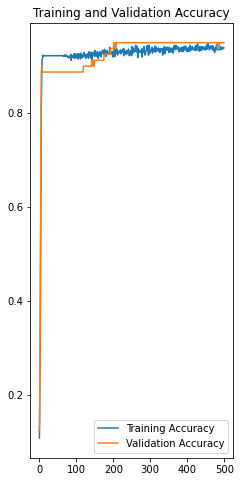

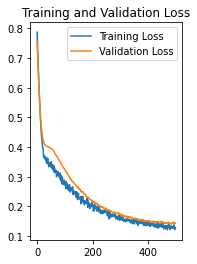

In [490]:
PrintLossAccuracyGraphs(history)

In [561]:
_,train_acc = model_scaled.evaluate(X_train_scaled, y_train)
_,test_acc = model_scaled.evaluate(X_test_scaled, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

13/13 [==============================] - 0s 834us/step - loss: 0.1333 - accuracy: 0.9650
Train: 0.942, Test: 0.965


In [562]:
#TRAINING SET.
y_train_predictions_prob = model_scaled.predict(X_train_scaled)
y_train_predictions = y_train_predictions_prob.round()

In [563]:
print(classification_report(y_train, y_train_predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       735
           1       0.74      0.45      0.56        65

    accuracy                           0.94       800
   macro avg       0.85      0.72      0.76       800
weighted avg       0.94      0.94      0.94       800



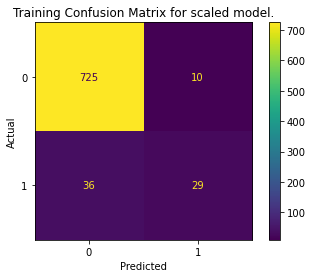

In [564]:
PrintConfusionMatrixOfModel(y_train,y_train_predictions,"Training Confusion Matrix for scaled model.")

In [565]:
df_false_negatives_training = GetFalseNegativePokemon(df_training_data,y_train,y_train_predictions)
df_false_negatives_training

,ID,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,Legendary
18,704,TornadusTherian Forme,Flying,NaN,580,79,100,80,110,90,121,5,1
40,263,Raikou,Electric,NaN,580,90,85,75,115,100,115,2,1
51,429,DeoxysNormal Forme,Psychic,NaN,600,50,150,50,150,50,150,3,1
81,700,Cobalion,Steel,Fighting,580,91,90,129,90,72,108,5,1
83,420,Latios,Dragon,Psychic,600,80,90,80,130,110,110,3,1
97,418,Latias,Dragon,Psychic,600,80,80,90,110,130,110,3,1
108,796,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,1
123,702,Virizion,Grass,Fighting,580,91,90,72,90,129,108,5,1
184,416,Regice,Ice,NaN,580,80,50,100,100,200,50,3,1
200,554,Victini,Psychic,Fire,600,100,100,100,100,100,100,5,1


In [566]:
PrintMeanOfPokemonFeaturesInDataframe("false negatives training data",df_false_negatives_training)

Mean of features of false negatives training data is 98.2407407407407


In [567]:
df_false_positives_training = GetFalsePositivePokemon(df_training_data,y_train,y_train_predictions)
df_false_positives_training

,ID,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,Legendary
35,276,SceptileMega Sceptile,Grass,Dragon,630,70,110,75,145,85,145,3,0
44,103,GengarMega Gengar,Ghost,Poison,600,60,65,80,170,95,130,1,0
111,410,SalamenceMega Salamence,Dragon,Flying,700,95,145,130,120,90,120,3,0
203,13,BlastoiseMega Blastoise,Water,NaN,630,79,103,120,135,115,78,1,0
301,72,AlakazamMega Alakazam,Psychic,NaN,590,55,50,65,175,95,150,1,0
329,414,MetagrossMega Metagross,Steel,Psychic,700,80,145,150,105,110,110,3,0
403,269,TyranitarMega Tyranitar,Rock,Dark,700,100,164,150,95,120,71,2,0
493,9,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,0
528,495,GarchompMega Garchomp,Dragon,Ground,700,108,170,115,120,95,92,4,0
650,307,GardevoirMega Gardevoir,Psychic,Fairy,618,68,85,65,165,135,100,3,0


In [568]:
PrintMeanOfPokemonFeaturesInDataframe("false positive training data",df_false_positives_training)

Mean of features of false positive training data is 108.36666666666665


In [569]:
df_correctly_predicted_legendaries_training =  GetCorrectlyPredictedLegendaryPokemon(df_training_data,y_train,y_train_predictions)
df_correctly_predicted_legendaries_training

,ID,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,Legendary
6,271,Ho-oh,Fire,Flying,680,106,130,90,110,154,90,2,1
27,421,LatiosMega Latios,Dragon,Psychic,700,80,130,100,160,120,110,3,1
50,425,GroudonPrimal Groudon,Ground,Fire,770,100,180,160,150,90,90,3,1
61,793,Xerneas,Fairy,NaN,680,126,131,95,131,98,99,6,1
66,794,Yveltal,Dark,Flying,680,126,131,95,131,98,99,6,1
70,712,KyuremBlack Kyurem,Dragon,Ice,700,125,170,100,120,90,95,5,1
109,711,Kyurem,Dragon,Ice,660,125,130,90,130,90,95,5,1
119,427,RayquazaMega Rayquaza,Dragon,Flying,780,105,180,100,180,100,115,3,1
137,553,Arceus,Normal,NaN,720,120,120,120,120,120,120,4,1
180,163,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,1


In [570]:
PrintMeanOfPokemonFeaturesInDataframe("correctly predicted training data",df_correctly_predicted_legendaries_training)

Mean of features of correctly predicted training data is 116.14942528735634


In [571]:
#TEST SET.
y_test_predictions_prob = model_scaled.predict(X_test_scaled)
y_test_predictions = y_test_predictions_prob.round()

In [572]:
print(classification_report(y_test, y_test_predictions))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       397
           1       0.18      1.00      0.30         3

    accuracy                           0.96       400
   macro avg       0.59      0.98      0.64       400
weighted avg       0.99      0.96      0.98       400



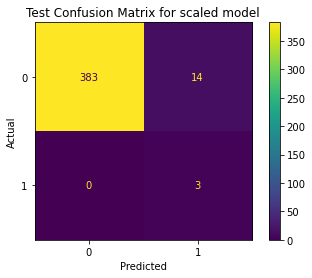

In [573]:
PrintConfusionMatrixOfModel(y_test,y_test_predictions,"Test Confusion Matrix for scaled model")

In [574]:
GetFalseNegativePokemon(df_test_data,y_test,y_test_predictions)

""


In [575]:
df_false_positive_test_data = GetFalsePositivePokemon(df_test_data,y_test,y_test_predictions)
df_false_positive_test_data

,No.,Name,Ability1,Ability2,Hidden_Ability,Type1,Type2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Weight_kg,Height_m,Weight_lbs,Height_ft,Cap_Rate,Egg_Steps,Classification,Legendary
27,259,Togekiss,Hustle,Serene Grace,Super Luck,fairy,flying,85,50,95,120,115,80,38.0,1.5,83.8,4.917,30,2560,Jubilee Pokémon,0
85,177,Noivern,Frisk,Infiltrator,Telepathy,flying,dragon,85,70,80,97,80,123,85.0,1.5,187.4,4.917,45,5120,Sound Wave Pokémon,0
92,397,Dragapult,Clear Body,Infiltrator,Cursed Body,dragon,ghost,88,120,75,100,75,142,50.0,3.0,110.2,9.833,45,10240,Stealth Pokémon,0
113,9,Inteleon,Torrent,NaN,Sniper,water,NaN,70,85,65,125,65,120,45.2,1.9,99.6,6.250,45,5120,Secret Agent Pokémon,0
138,380,Charizard,Blaze,NaN,Solar Power,fire,flying,78,84,78,109,85,100,90.5,1.7,199.5,5.583,45,5120,Flame Pokémon,0
139,385,Tyranitar,Sand Stream,NaN,Unnerve,rock,dark,100,134,110,95,100,61,202.0,2.0,445.3,6.583,45,10240,Armor Pokémon,0
228,388,Hydreigon,Levitate,NaN,NaN,dark,dragon,92,105,90,125,90,98,160.0,1.8,352.7,5.917,45,10240,Brutal Pokémon,0
267,71,Arcanine,Intimidate,Flash Fire,Justified,fire,NaN,90,110,80,100,80,95,155.0,1.9,341.7,6.250,75,5120,Legendary Pokémon,0
268,198,Jolteon,Volt Absorb,NaN,Quick Feet,electric,NaN,65,65,60,110,95,130,24.5,0.8,54.0,2.583,45,8960,Lightning Pokémon,0
278,391,Goodra,Sap Sipper,Hydration,Gooey,dragon,NaN,90,100,70,110,150,80,150.5,2.0,331.8,6.583,45,10240,Dragon Pokémon,0


In [576]:
PrintMeanOfPokemonFeaturesInDataframe("false positive test data",df_false_positive_test_data)

Mean of features of false positive test data is 93.55952380952381


In [577]:
df_correctly_predicted_legendaries_test_data = GetCorrectlyPredictedLegendaryPokemon(df_test_data,y_test,y_test_predictions)
df_correctly_predicted_legendaries_test_data

,No.,Name,Ability1,Ability2,Hidden_Ability,Type1,Type2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Weight_kg,Height_m,Weight_lbs,Height_ft,Cap_Rate,Egg_Steps,Classification,Legendary
25,399,Zamazenta,Dauntless Shield,NaN,NaN,fighting,NaN,92,130,115,80,115,138,210.0,2.9,463.0,9.500,10,30720,Warrior Pokémon,1
78,400,Eternatus,Pressure,NaN,NaN,poison,dragon,140,85,95,145,95,130,950.0,20.0,2094.4,65.583,255,30720,Gigantic Pokémon,1
384,398,Zacian,Intrepid Sword,NaN,NaN,fairy,NaN,92,130,115,80,115,138,110.0,2.8,242.5,9.167,10,30720,Warrior Pokémon,1


In [578]:
PrintMeanOfPokemonFeaturesInDataframe("correctly predicted test data",df_correctly_predicted_legendaries_test_data)

Mean of features of correctly predicted test data is 112.77777777777779


In [375]:
#Model 2 - .

In [347]:
model2 = CreateModel2()

history2 = model2.fit(X_train_scaled, y_train,validation_split = 0.1,batch_size=64,epochs=500,callbacks=[earlystopping])

Epoch 1/500
12/12 [==============================] - 0s 14ms/step - loss: 0.8117 - accuracy: 0.2431 - val_loss: 0.7687 - val_accuracy: 0.2000
Epoch 2/500
12/12 [==============================] - 0s 2ms/step - loss: 0.7601 - accuracy: 0.3653 - val_loss: 0.7326 - val_accuracy: 0.3625
Epoch 3/500
12/12 [==============================] - 0s 3ms/step - loss: 0.7241 - accuracy: 0.5278 - val_loss: 0.7039 - val_accuracy: 0.6000
Epoch 4/500
12/12 [==============================] - 0s 2ms/step - loss: 0.6948 - accuracy: 0.6569 - val_loss: 0.6799 - val_accuracy: 0.6625
Epoch 5/500
12/12 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.7764 - val_loss: 0.6596 - val_accuracy: 0.7250
Epoch 6/500
12/12 [==============================] - 0s 2ms/step - loss: 0.6424 - accuracy: 0.8458 - val_loss: 0.6423 - val_accuracy: 0.8000
Epoch 7/500
12/12 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.8653 - val_loss: 0.6267 - val_accuracy: 0.8375
Epoch 8/500


Epoch 59/500
12/12 [==============================] - 0s 3ms/step - loss: 0.2804 - accuracy: 0.9236 - val_loss: 0.3696 - val_accuracy: 0.8750
Epoch 60/500
12/12 [==============================] - 0s 3ms/step - loss: 0.2707 - accuracy: 0.9236 - val_loss: 0.3694 - val_accuracy: 0.8750
Epoch 61/500
12/12 [==============================] - 0s 2ms/step - loss: 0.2804 - accuracy: 0.9236 - val_loss: 0.3697 - val_accuracy: 0.8750
Epoch 62/500
12/12 [==============================] - 0s 3ms/step - loss: 0.2824 - accuracy: 0.9236 - val_loss: 0.3694 - val_accuracy: 0.8750
Epoch 63/500
12/12 [==============================] - 0s 3ms/step - loss: 0.2782 - accuracy: 0.9236 - val_loss: 0.3688 - val_accuracy: 0.8750
Epoch 64/500
12/12 [==============================] - 0s 2ms/step - loss: 0.2752 - accuracy: 0.9236 - val_loss: 0.3683 - val_accuracy: 0.8750
Epoch 65/500
12/12 [==============================] - 0s 3ms/step - loss: 0.2735 - accuracy: 0.9236 - val_loss: 0.3678 - val_accuracy: 0.8750
Epoch 

12/12 [==============================] - 0s 3ms/step - loss: 0.1785 - accuracy: 0.9319 - val_loss: 0.2855 - val_accuracy: 0.8750
Epoch 174/500
12/12 [==============================] - 0s 2ms/step - loss: 0.1945 - accuracy: 0.9389 - val_loss: 0.2815 - val_accuracy: 0.8750
Epoch 175/500
12/12 [==============================] - 0s 3ms/step - loss: 0.2091 - accuracy: 0.9278 - val_loss: 0.2829 - val_accuracy: 0.8750
Epoch 176/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1978 - accuracy: 0.9333 - val_loss: 0.2810 - val_accuracy: 0.8750
Epoch 177/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1997 - accuracy: 0.9278 - val_loss: 0.2792 - val_accuracy: 0.8750
Epoch 178/500
12/12 [==============================] - 0s 3ms/step - loss: 0.2177 - accuracy: 0.9333 - val_loss: 0.2809 - val_accuracy: 0.8750
Epoch 179/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1777 - accuracy: 0.9319 - val_loss: 0.2796 - val_accuracy: 0.8750
Epoch 180/500

12/12 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.9403 - val_loss: 0.2470 - val_accuracy: 0.8750
Epoch 288/500
12/12 [==============================] - 0s 2ms/step - loss: 0.1736 - accuracy: 0.9347 - val_loss: 0.2467 - val_accuracy: 0.8750
Epoch 289/500
12/12 [==============================] - 0s 2ms/step - loss: 0.1920 - accuracy: 0.9347 - val_loss: 0.2493 - val_accuracy: 0.8750
Epoch 290/500
12/12 [==============================] - 0s 2ms/step - loss: 0.1568 - accuracy: 0.9431 - val_loss: 0.2474 - val_accuracy: 0.8750
Epoch 291/500
12/12 [==============================] - 0s 3ms/step - loss: 0.1690 - accuracy: 0.9375 - val_loss: 0.2424 - val_accuracy: 0.8750
Epoch 292/500
12/12 [==============================] - 0s 2ms/step - loss: 0.1653 - accuracy: 0.9431 - val_loss: 0.2400 - val_accuracy: 0.8750
Epoch 293/500
12/12 [==============================] - 0s 2ms/step - loss: 0.1916 - accuracy: 0.9361 - val_loss: 0.2434 - val_accuracy: 0.8750
Epoch 294/500

In [348]:
#PrintLossAccuracyGraphs(history2)

In [221]:
_,train_acc = model2.evaluate(X_train_scaled, y_train)
_,test_acc = model2.evaluate(X_test_scaled, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

13/13 [==============================] - 0s 750us/step - loss: 0.0719 - accuracy: 0.9925
Train: 0.924, Test: 0.993


In [222]:
#TRAINING SET.
model2_y_train_predictions_prob = model2.predict(X_train_scaled)
model2_y_train_predictions = model2_y_train_predictions_prob.round()

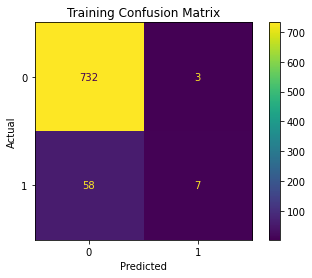

In [223]:
PrintConfusionMatrixOfModel(y_train,model2_y_train_predictions,"Training Confusion Matrix")

In [224]:
model2_y_test_predictions_prob = model2.predict(X_test_scaled)
model2_y_test_predictions = model2_y_test_predictions_prob.round()

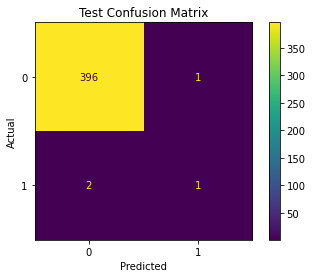

In [225]:
PrintConfusionMatrixOfModel(y_test,model2_y_test_predictions,"Test Confusion Matrix")